## Training Data

Designing training data sets for the MLP

Importing libraries and redefining the noise and convolution functions from the RL workbook

In [174]:
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt
import torch

In [175]:
def gaussian_kernel_1D(size=21, sigma=2.0):
    ax = torch.linspace(-(size // 2), size // 2, size)
    kernel = torch.exp(-0.5 * (ax / sigma) ** 2)
    kernel = kernel / kernel.sum()
    return kernel

def poisson_noise(y, scale_factor=1000):
    photon_counts = y * scale_factor
    noisy_photons = torch.poisson(photon_counts)
    noisy_y = noisy_photons / scale_factor
    return torch.clamp(noisy_y, 0, 1)

def convo1d(image, kernel):

    if image.dim() == 1:
        image = image.unsqueeze(0).unsqueeze(0)  
    elif image.dim() == 2:
        image = image.unsqueeze(0)  

    if kernel.dim() == 1:
        kernel = kernel.unsqueeze(0).unsqueeze(0)
    elif kernel.dim() == 2:
        kernel = kernel.unsqueeze(0)
    
    padding = (kernel.shape[-1] - 1) // 2
    result = torch.nn.functional.conv1d(image, kernel, padding=padding)
    
    return result.squeeze()


Creates 4 different types of functions (sin, step, normal, triangular) and adds blur and noise to every function. 

In [182]:
def create_training_data(data_len, data_size, num_points, scale_factor=1000, seed=42):
    
    rng = np.random.default_rng(seed)

    x = torch.linspace(0, data_len, data_size)
    x = x.float()

    clean_data = {}
    blur_data = {}


    def blur_and_noise(y):
        y = y * (0.9 - 0.1) + 0.1
        y = convo1d(y, gaussian_kernel_1D(size=21, sigma=2.0))
        y = poisson_noise(y, scale_factor)
        y = y.numpy()
        return y

    for i in range(num_points//4):
        y = 0.5*torch.sin(x*rng.uniform(0,2)) + 0.5
        clean_data[f'y_clean_{i}'] = y.numpy()
        blur_data[f'y_blur_{i}'] = blur_and_noise(y)

    for i in range(num_points//4):
        period = rng.uniform(0.5, 2.0)
        y = (torch.sign(torch.sin(2 * torch.pi * x / period)) + 1) / 2
        clean_data[f'y_clean_{i + num_points//4}'] = y.numpy()
        blur_data[f'y_blur_{i + num_points//4}'] = blur_and_noise(y)

    for i in range(num_points//4):
        mean = rng.uniform(data_len * 0.2, data_len * 0.8)
        std = rng.uniform(1, 3)
        y = torch.exp(-0.5 * ((x - mean) / std) ** 2)
        clean_data[f'y_clean_{i + 2*num_points//4}'] = y.numpy()
        blur_data[f'y_blur_{i + 2*num_points//4}'] = blur_and_noise(y)

    for i in range(num_points//4):
        period = rng.uniform(0.5, 2.0)
        y = ((x % period) / period)
        clean_data[f'y_clean_{i + 3*num_points//4}'] = y.numpy()
        blur_data[f'y_blur_{i + 3*num_points//4}'] = blur_and_noise(y)

    x_df = pd.DataFrame({'x': x.numpy()})
    clean_df = pd.DataFrame(clean_data)
    blur_df = pd.DataFrame(blur_data)
    
    training_data = pd.concat([x_df, clean_df, blur_df], axis=1)

    return training_data




Call function and test:

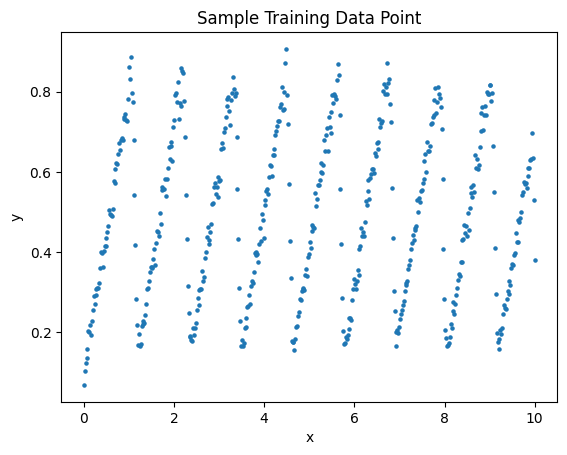

1854


,x,y_clean_0,y_clean_1,y_clean_2,y_clean_3,y_clean_4,y_clean_5,y_clean_6,y_clean_7,y_clean_8,...,y_blur_1990,y_blur_1991,y_blur_1992,y_blur_1993,y_blur_1994,y_blur_1995,y_blur_1996,y_blur_1997,y_blur_1998,y_blur_1999
0,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.076,0.073,0.079,0.061,0.068,0.065,0.064,0.083,0.056,0.079
1,0.020040,0.515508,0.508795,0.517203,0.513973,0.501887,0.519547,0.515251,0.515750,0.502567,...,0.103,0.105,0.107,0.071,0.098,0.093,0.113,0.094,0.091,0.091
2,0.040080,0.531000,0.517587,0.534386,0.527936,0.503775,0.539063,0.530488,0.531485,0.505135,...,0.114,0.132,0.149,0.096,0.104,0.112,0.112,0.143,0.106,0.135
3,0.060120,0.546463,0.526373,0.551527,0.541877,0.505662,0.558520,0.545696,0.547188,0.507702,...,0.118,0.159,0.159,0.142,0.118,0.124,0.131,0.143,0.126,0.135
4,0.080160,0.561881,0.535152,0.568608,0.555785,0.507549,0.577888,0.560862,0.562845,0.510269,...,0.135,0.143,0.206,0.145,0.124,0.158,0.165,0.188,0.142,0.139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,9.919840,0.672821,0.828778,0.014865,0.977430,0.978014,0.742551,0.785283,0.556230,0.782263,...,0.178,0.593,0.266,0.312,0.429,0.679,0.478,0.207,0.709,0.808
496,9.939879,0.658186,0.822101,0.010989,0.981394,0.977457,0.759458,0.772626,0.540552,0.780140,...,0.216,0.422,0.272,0.313,0.419,0.688,0.487,0.196,0.626,0.732
497,9.959920,0.643399,0.815325,0.007691,0.984983,0.976893,0.775968,0.759715,0.524834,0.778010,...,0.210,0.285,0.290,0.306,0.466,0.667,0.430,0.202,0.624,0.680
498,9.979959,0.628474,0.808451,0.004977,0.988192,0.976323,0.792057,0.746562,0.509091,0.775872,...,0.172,0.182,0.277,0.253,0.354,0.610,0.384,0.192,0.570,0.581


In [183]:

num_points = 2000

rng = np.random.default_rng()
pick = rng.integers(0, num_points)


training_data = create_training_data(data_len=10, data_size=500, num_points=num_points, scale_factor=1000, seed=42)

# #training_data.plot(x='x', y='y_1', kind='scatter')
plt.scatter(training_data['x'], training_data[f'y_blur_{pick}'], s=5)
plt.title('Sample Training Data Point')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print(pick)

training_data

#training_data.info()


